# Value factor

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import keyring
import platform

In [5]:
# database connection info
user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.112' if platform.system() == 'Windows' else '127.0.0.1'
port = 3306
db = 'stock'

In [6]:
# connect db
engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:{port}/{db}')

ticker_list = pd.read_sql(
    """ 
    SELECT * FROM ticker_kr
    WHERE date = (SELECT MAX(date) FROM ticker_kr)
    AND category='보통주';
    """
, con=engine)

value_list = pd.read_sql(
    """ 
    SELECT * FROM value_kr
    WHERE date = (SELECT MAX(date) FROM value_kr)
    """
, con=engine)
engine.dispose()

## Value factor with PER, PBR

In [7]:
# in case that value is less than 0 (ex. ndfffegative PER), transform the data into nan
value_list.loc[value_list['value'] < 0, 'value'] = np.nan
# transform the table into vertical form using pivot() function
value_pivot = value_list.pivot(index='company_code', columns='ratio', values='value')
# merge ticker table and value table
data_bind = ticker_list[['company_code', 'company']].merge(value_pivot, how='left', on='company_code')
data_bind.head()

,company_code,company,DY,PBR,PCR,PER,PSR
0,000020,동화약품,0.0188,0.683526,7.288142,9.135137,0.738091
1,000040,KR모터스,NaN,1.469331,NaN,NaN,0.509742
2,000050,경방,0.0143,0.319985,5.816569,NaN,0.627786
3,000070,삼양홀딩스,0.0472,0.244519,2.314162,2.821798,0.197357
4,000080,하이트진로,0.0482,1.221684,NaN,79.822543,0.550588


In [8]:
# Find lowest PER and PBR stocks

# rank the stocks with PER and PBR column, with axis=0 (column-wise)
value_rank = data_bind[['PER', 'PBR']].rank(axis=0)

# sum the rank with axis=1 (row-wise)
# drop stocks with NA value 
# re-rank with sum of two ranks
value_sum = value_rank.sum(axis=1, skipna=False).rank()

# top lowest 20 stocks
data_bind.loc[value_sum <= 20, ['company_code', 'company', 'PER', 'PBR']]

,company_code,company,PER,PBR
40,000880,한화,2.172238,0.071709
43,000950,전방,0.737075,0.188912
65,001390,KG케미칼,0.692322,0.127756
153,003300,한일홀딩스,2.294874,0.187446
156,003380,하림지주,1.606367,0.155161
247,005720,넥센,2.800099,0.103831
262,005990,매일홀딩스,2.332994,0.159849
268,006120,SK디스커버리,2.094585,0.141632
289,006840,AK홀딩스,2.561308,0.159704
315,007700,F&F홀딩스,1.256456,0.200060


## Value factor with various features

In [9]:
# PER, PBR, PCR, PSR, DY

value_list_copy = data_bind.copy()
# lower PER, PBR, PCR, PSR, more value while higher DY, more value
value_list_copy['DY'] = 1 / value_list_copy['DY']
value_list_copy = value_list_copy[['PER', 'PBR', 'PCR', 'PSR', 'DY']]
# rank each value with column wise
value_rank_all = value_list_copy.rank(axis=0)

# re-rank after sum of each rank
value_sum_all = value_rank_all.sum(axis=1, skipna=False).rank()
# pick lowest rank 20 stocks
data_bind.loc[value_sum_all <= 20]

,company_code,company,DY,PBR,PCR,PER,PSR
17,000320,노루홀딩스,0.0414,0.239568,1.838558,2.937660,0.133641
38,000850,화천기공,0.0769,0.206887,2.090643,1.975138,0.305686
40,000880,한화,0.0252,0.071709,0.720663,2.172238,0.036195
52,001120,LX인터내셔널,0.1130,0.328882,1.181628,2.897185,0.069011
153,003300,한일홀딩스,0.0629,0.187446,2.364039,2.294874,0.170319
219,004960,한신공영,0.0428,0.111538,1.148875,3.037850,0.060962
226,005090,SGC에너지,0.0736,0.386570,1.790511,3.906761,0.104846
262,005990,매일홀딩스,0.0187,0.159849,0.688928,2.332994,0.051618
268,006120,SK디스커버리,0.0379,0.141632,1.865968,2.094585,0.091901
355,009410,태영건설,0.0968,0.111924,4.544744,0.908036,0.028355


# Momentum factor

In [10]:
ticker_list = pd.read_sql(
    """ 
    SELECT * FROM ticker_kr
    WHERE date = (SELECT MAX(date) FROM ticker_kr)
    AND category = '보통주';
    """
, con=engine)

# get recent 1 year data.
price_list = pd.read_sql(
    """ 
    SELECT date, close, company_code
    FROM price_kr
    WHERE date >= (SELECT (SELECT MAX(date) FROM price_kr) - interval 1 year);
    """
, con=engine)

engine.dispose()
price_list.head()

,date,close,company_code
0,2023-03-15,8420.0,000020
1,2023-03-15,457.0,000040
2,2023-03-15,10850.0,000050
3,2023-03-15,74300.0,000070
4,2023-03-15,22250.0,000080


In [11]:
price_pivot = price_list.pivot(index='date', columns='company_code', values='close')
price_pivot.iloc[0:5, 0:5]

company_code,000020,000040,000050,000070,000080
date,,,,,
2023-03-15,8420.0,457.0,10850.0,74300.0,22250.0
2023-03-16,8330.0,450.0,10550.0,74000.0,22200.0
2023-03-17,8430.0,517.0,10630.0,74100.0,22600.0
2023-03-20,8460.0,496.0,10600.0,71900.0,22100.0
2023-03-21,8550.0,495.0,10610.0,72900.0,21750.0


In [12]:
ret_list = pd.DataFrame(
    data=(price_pivot.iloc[-1] / price_pivot.iloc[0]) - 1,
    columns=['return']
)
data_bind = ticker_list[['company_code', 'company']].merge(ret_list, how='left', on='company_code')
data_bind.head()

,company_code,company,return
0,000020,동화약품,0.110451
1,000040,KR모터스,0.017505
2,000050,경방,-0.219355
3,000070,삼양홀딩스,-0.040377
4,000080,하이트진로,-0.087640


In [13]:
# top highest return stocks
momentum_rank = data_bind['return'].rank(axis=0, ascending=False)
data_bind[momentum_rank <= 20]

,company_code,company,return
312,007660,이수페타시스,3.119458
565,022100,포스코DX,7.814935
605,025320,시노펙스,2.964427
666,031980,피에스케이홀딩스,4.000000
850,042700,한미반도체,5.760365
1085,065350,신성델타테크,7.400994
1112,066790,씨씨에스,9.921844
1214,078860,아이오케이,10.776650
1235,080220,제주반도체,4.238589
1310,089030,테크윙,4.362832


In [14]:
# plot graph
price_momentum = price_list[price_list['company_code'].isin(
    data_bind.loc[momentum_rank <= 20, 'company_code']
)]
price_momentum

,date,close,company_code
313,2023-03-15,8120.0,007660
565,2023-03-15,6160.0,022100
605,2023-03-15,2530.0,025320
666,2023-03-15,8210.0,031980
850,2023-03-15,14230.0,042700
...,...,...,...
585326,2024-03-15,16050.0,253590
585409,2024-03-15,26750.0,281740
585439,2024-03-15,2470.0,290690
585700,2024-03-15,101500.0,399720


c:\Users\woojin\anaconda3\envs\finance\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


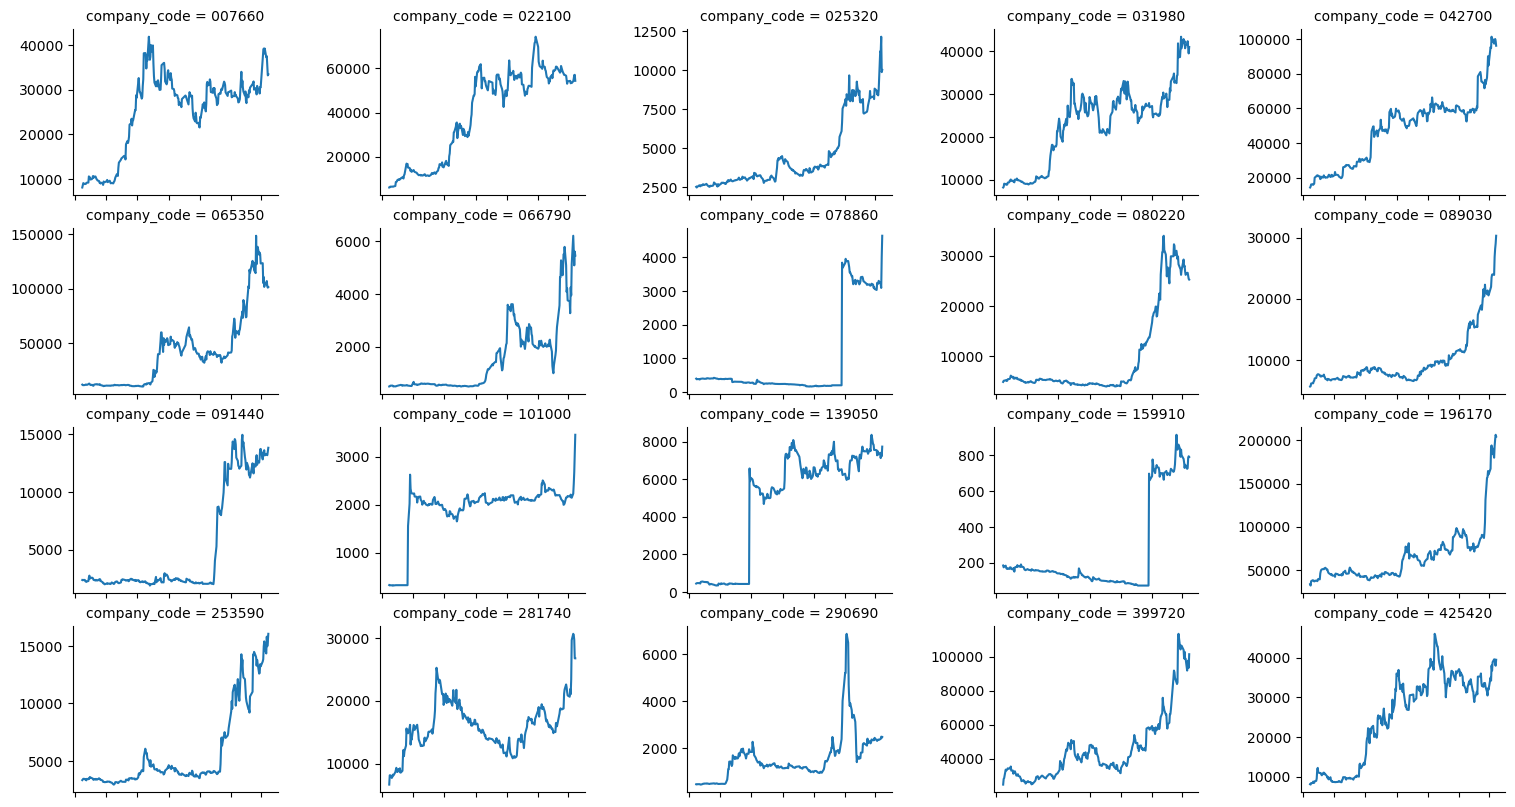

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.relplot(
    data=price_momentum,
    x='date',
    y='close',
    col='company_code',
    col_wrap=5,
    kind='line',
    facet_kws={
        'sharey': False,
        'sharex': True
    }
)
g.set(xticklabels=[])
g.set(xlabel=None)
g.set(ylabel=None)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.show()

## K-ratio

In [16]:
import statsmodels.api as sm
import numpy as np

# calculate return of each stock and drop first row having no return value
ret = price_pivot.pct_change().iloc[1:]
# add 1 to return, take logarithm and sum cumulatively (= cumsum log return)
ret_cum = np.log(1 + ret).cumsum()

# x-axis : period
# y-axis : cumsum log return
x = np.array(range(len(ret)))
y = ret_cum.iloc[:, 0].values

In [17]:
# k-ratio of a stock
reg = sm.OLS(y, x).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              804.0
Date:                Sat, 25 May 2024   Prob (F-statistic):                    2.45e-79
Time:                        20:07:41   Log-Likelihood:                          291.75
No. Observations:                 246   AIC:                                     -581.5
Df Residuals:                     245   BIC:                                     -578.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0009   3.33e-05     28.356      0.000       0.001       0.001
==============================================================================
Omnibus:                       14.768   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.817
Skew:                           0.596   Prob(JB):                     0.000368
Kurtosis:                       2.651   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# k-ratio
print(reg.params, reg.bse, (reg.params / reg.bse))

[0.00094561] [3.33482995e-05] [28.35568771]


In [19]:
# k ratio of all stocks
x = np.array(range(len(ret)))
k_ratio = {}

for i in range(0, len(ticker_list)):
    
    ticker = data_bind.loc[i, 'company_code']
    
    try:
        y = ret_cum.loc[:, price_pivot.columns == ticker]
        reg = sm.OLS(y, x).fit()
        res = float(reg.params / reg.bse)
    except:
        res = np.nan 
    
    k_ratio[ticker] = res

k_ratio_bind = pd.DataFrame.from_dict(k_ratio, orient='index').reset_index()
k_ratio_bind.columns = ['company_code', 'K_ratio']

k_ratio_bind.head()

C:\Users\woojin\AppData\Local\Temp\ipykernel_16452\1662629707.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res = float(reg.params / reg.bse)


,company_code,K_ratio
0,000020,28.355688
1,000040,2.772770
2,000050,-50.450499
3,000070,-22.256113
4,000080,-10.555229


In [20]:
# rank k-ratio
data_bind = data_bind.merge(k_ratio_bind, how='left', on='company_code')
data_bind

,company_code,company,return,K_ratio
0,000020,동화약품,0.110451,28.355688
1,000040,KR모터스,0.017505,2.772770
2,000050,경방,-0.219355,-50.450499
3,000070,삼양홀딩스,-0.040377,-22.256113
4,000080,하이트진로,-0.087640,-10.555229
...,...,...,...,...
2413,460860,동국제강,NaN,NaN
2414,460930,현대힘스,NaN,NaN
2415,462520,조선내화,NaN,NaN
2416,465770,STX그린로지스,NaN,NaN


In [21]:
k_ratio_rank = data_bind['K_ratio'].rank(axis=0, ascending=False)
data_bind[k_ratio_rank <= 20]

,company_code,company,return,K_ratio
20,000400,롯데손해보험,1.049356,66.511631
31,000660,SK하이닉스,1.037927,77.288062
356,009420,한올바이오파마,1.199145,70.565257
520,017940,E1,0.493107,78.231093
526,018290,브이티,2.000000,65.763378
565,022100,포스코DX,7.814935,66.582021
589,024110,기업은행,0.581950,64.952060
769,036930,주성엔지니어링,2.275696,65.340814
802,039030,이오테크닉스,1.539118,65.979541
850,042700,한미반도체,5.760365,73.669355


c:\Users\woojin\anaconda3\envs\finance\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


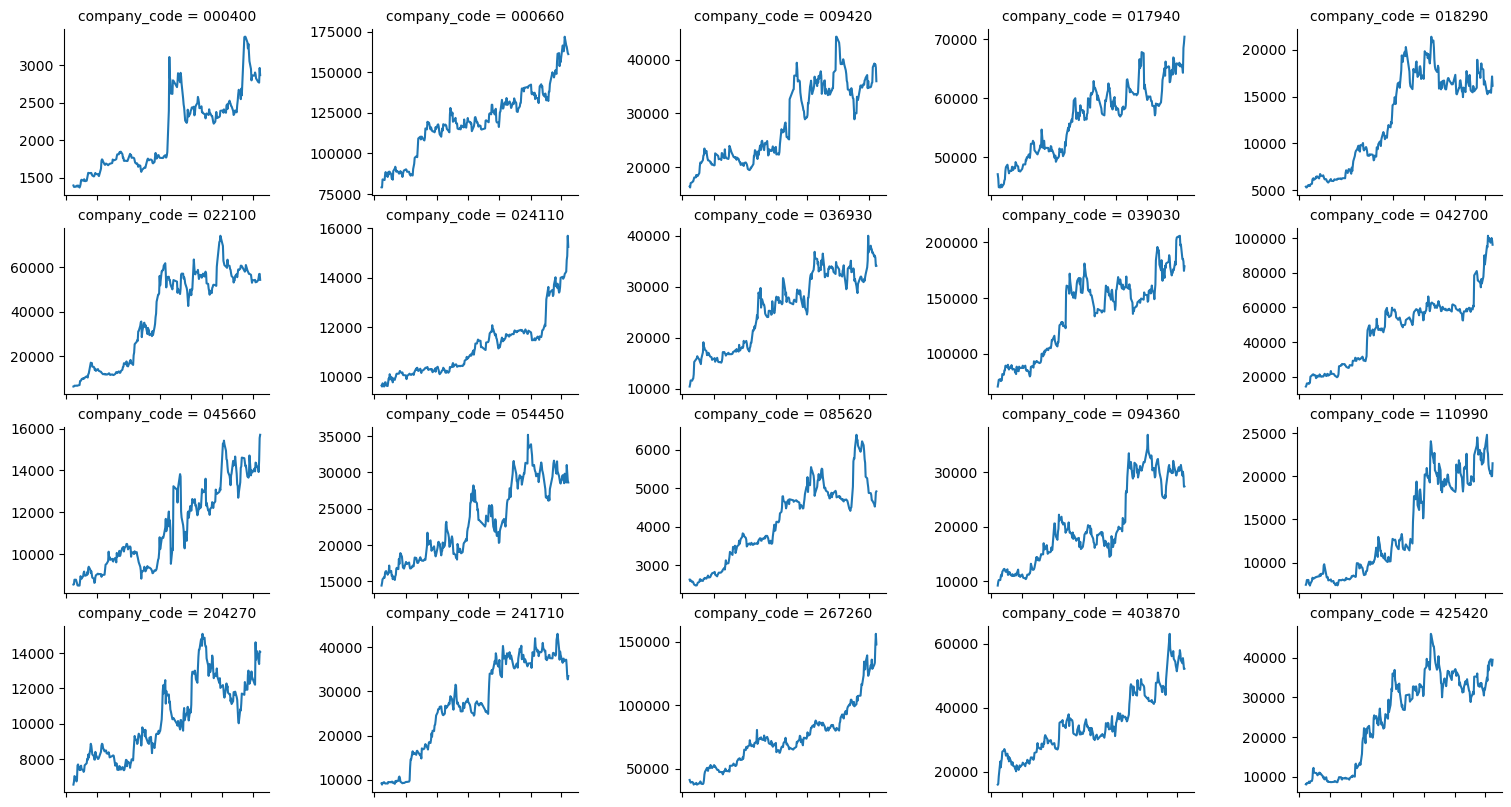

In [22]:
# plot price graph
k_ratio_momentum = price_list[price_list['company_code'].isin(
    data_bind.loc[k_ratio_rank <= 20, 'company_code']
)]

g = sns.relplot(
    data=k_ratio_momentum,
    x='date',
    y='close',
    col='company_code',
    col_wrap=5,
    kind='line',
    facet_kws={
        'sharey': False,
        'sharex': True
    }
)
g.set(xticklabels=[])
g.set(xlabel=None)
g.set(ylabel=None)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.show()

# Quality factor

In [23]:
# quality
ticker_list = pd.read_sql(
    """ 
    SELECT * FROM ticker_kr
    WHERE date = (SELECT MAX(date) FROM ticker_kr)
    AND category = '보통주';
    """
, con=engine)

fs_list = pd.read_sql(
    """ 
    SELECT * FROM fs_kr
    WHERE account IN ('당기순이익', '매출총이익', '영업활동으로인한현금흐름', '자산', '자본')
    AND frequency = 'q';
    """
, con=engine)
engine.dispose()

In [24]:
# sort values
fs_list = fs_list.sort_values(['company_code', 'account', 'date'])
# for getting TTM value, sum 4 quarters by rolling() method with binding company_code and account
fs_list['ttm'] = fs_list.groupby(['company_code', 'account'], as_index=False)['value'].rolling(
    window=4, min_periods=4
).sum()['value']
fs_list_clean = fs_list.copy()

# get average of asset and capital, and sum all other accounts
fs_list_clean['ttm'] = np.where(fs_list_clean['account'].isin(['자산', '자본']),
                                fs_list_clean['ttm'] / 4, fs_list_clean['ttm'])

# select recent data per company_code and account using tail(1) method
fs_list_clean = fs_list_clean.groupby(['company_code', 'account']).tail(1)

fs_list_pivot = fs_list_clean.pivot(index='company_code', columns='account', values='ttm')
fs_list_pivot['ROE'] = fs_list_pivot['당기순이익'] / fs_list_pivot['자본']
fs_list_pivot['GPA'] = fs_list_pivot['매출총이익'] / fs_list_pivot['자산']
fs_list_pivot['CFO'] = fs_list_pivot['영업활동으로인한현금흐름'] / fs_list_pivot['자산']

# merge ticker table
quality_list = ticker_list[['company_code', 'company']].merge(
    fs_list_pivot,
    how='left',
    on='company_code'
)
quality_list.round(4).head()

,company_code,company,당기순이익,매출총이익,영업활동으로인한현금흐름,자본,자산,ROE,GPA,CFO
0,000020,동화약품,292.0,1897.0,366.0,3902.50,4775.25,0.0748,0.3973,0.0766
1,000040,KR모터스,-278.0,90.0,-61.0,304.25,1513.25,-0.9137,0.0595,-0.0403
2,000050,경방,-100.0,977.0,411.0,7471.00,12330.75,-0.0134,0.0792,0.0333
3,000070,삼양홀딩스,2252.0,5089.0,2746.0,25988.50,46164.00,0.0867,0.1102,0.0595
4,000080,하이트진로,173.0,10808.0,-223.0,11303.50,33565.00,0.0153,0.3220,-0.0066


In [25]:
# rank quality factor
quality_list_copy = quality_list[['ROE', 'GPA', 'CFO']].copy()
quality_rank = quality_list_copy.rank(ascending=False, axis=0)

In [26]:
# adding three values and re-rank 
quality_sum = quality_rank.sum(axis=1, skipna=False).rank()
# lowest 20 stocks
quality_list.loc[quality_sum <= 20,
                 ['company_code', 'company', 'ROE', 'GPA', 'CFO']].round(4)

,company_code,company,ROE,GPA,CFO
136,002960,한국쉘석유,0.3213,0.5748,0.2599
690,033100,제룡전기,0.4981,0.6516,0.2759
724,034950,한국기업평가,0.2143,0.6150,0.1780
741,035900,JYP Ent.,0.3323,0.5261,0.2702
803,039130,하나투어,0.4655,0.6459,0.2196
923,049720,고려신용정보,0.3047,1.7778,0.1975
1027,058630,엠게임,0.2304,0.6559,0.3145
1120,067160,아프리카TV,0.2362,0.6550,0.2112
1346,092130,이크레더블,0.2896,0.7399,0.2160
1369,094170,동운아나텍,0.5725,0.6263,0.3400


# Magic equation


In [27]:
# correlation between Quality factor (revenue) and Value factor (PBR)
 